<a href="https://colab.research.google.com/github/yh0010/ML_Final_Project/blob/main/Federated_ImageNette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federated Learning

## Introduction

It is common for many machine learning problems to start by first aggregating data across many different sources (servers, databases, mobile devices) into a central repository. This data can then be used to train a machine learning model.

One problem with this method is that it requires potentially sensitive data to be exported externally. Even if its anonymized, if an attacker gets their hands on this data, they can cross reference it with other datasets in order to trace back sensitive information about the data owner. Not only does this introduce new avenues of attack that can potentially destabilize the data owner's privacy, but it also introduces the question of scalability. How much would it cost to maintain all this remote data in a single central DB? For some high frequency and high volume datasets, the cost is just too high, and this method doesn't scale well.

Federated learning is an alternative paradigm for training models on data distributed across different remote sources that aims to solve this problem. Rather than aggregating the data from many different sources to a single central repository, in federated learning, the model itself is sent to the remote nodes. The model trains on the local data that is available on that resource and the new version of the model is sent back to the main process. This process can be repeated iteratively or in parallel across many different devices. There isn't any specefic sensitive information in the weights of the model alone, which helps ensure the privacy of the data owner.

For this project, we use PySyft, which is a Python package that allows us to simulate federated learning environments. PySyft provides an interface to distribute data and models across different virtual remote worker nodes. This allows us to construct scenarios that closely mimic federated learning in the real world.

In this notebook, we build on top of an [example notebook](https://github.com/OpenMined/PySyft/blob/PySyft/syft_0.2.x/examples/tutorials/Part%2007%20-%20Federated%20Learning%20with%20Federated%20Dataset.ipynb) available on the PySyft github page that trains a model on a simple federated dataset. In the notebook, the authors make a federated version of the Boston housing dataset and train a simple MLP classifier on the data. In this notebook, we follow a similar set of steps, however, we use a Resnet18 model and train it on the [imagenette](https://github.com/fastai/imagenette) dataset, which is a smaller version of the famous ImageNet dataset. In addition to training this new model using PySyft's federated learning environment, we also train the same model on the same dataset without using federated learning in order to explore some strengths and limitations of federated learning.

Note that this notebook by itself is not considered to be our extension of the original notebook. This was used during the presentation as a starting point to explore and discuss the limitations of federated learning. The actual extensions comes from the comparison we make between vanilla federated learning methods and differential privacy. Specifically, a differentially private implementation of SGD, as a way to maintain privacy during the learning process. This will be available as a seperate notebook.

We start by installing the necessary dependencies

In [ ]:
# install PySyft and restart the runtime
from IPython.display import clear_output
!pip install syft==0.2.9 >> /dev/null
clear_output()
exit()

In [ ]:
import os
import io
import time
import requests

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import syft as sy

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, models, transforms

torch.multiprocessing.set_start_method('spawn')

First, we download the imagenette dataset using fastai's vision library

In [ ]:
from fastai.vision import untar_data, imagenet_stats, URLs

# download data
path = untar_data(URLs.IMAGENETTE_160)

## Creating a Centralized Dataset

A centralized dataset is the kind that typically comes to mind when working on a Machine Learning problem. The data is stored in a single resource and can be accessed from a single development environment. As a result, much of the processing here is pretty standard. Here, we load the dataset from disk and apply some very simple pre-processing. We randomly crop the images, convert them to PyTorch tensors, and normalize the images with respect to the means for each color channel for the ImageNet dataset. The logic for loading this dataset was taken from this [PyTorch tutorial notebook](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [ ]:
def create_regular_dataset(path, normalize=False):
  transform_ops = [
    transforms.RandomResizedCrop(64),
    transforms.ToTensor()
  ]
  if normalize:
    transform_ops.append(transforms.Normalize(*imagenet_stats))
  global_transforms = transforms.Compose(transform_ops)
  
  image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                            global_transforms)
                  for x in ['train', 'val']}

  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                              shuffle=True, num_workers=1)
                  for x in ['train', 'val']}
  print('Created dataloaders')
  
  # convert the training data to a list, this will make it easier to 
  # keep track of the batches when we distribute the dataset
  dataloaders['train'] = [(data, target) for (data, target) in dataloaders['train']]
  return dataloaders

In [ ]:
regular_dataloader = create_regular_dataset(path, normalize=True)

Created dataloaders


Now that we have created our centralized dataset, let's train a simple ResNet18 model on this dataset. Note that we are particularly interested in optimizing performance, as a result, we make a few simplifications that make the learning process far simpler than one may expect when training this model on this dataset. First, we use a constant learning rate. Annealing the learning rate was recommended by many PyTorch tutorials, however, for this demo, it is not necessary. Second, we only train the model on a subset of the entire dataset. This is due to efficiency issues with PySyft. Our goal here is to make an even comparison between a regular model and a model trained in a federated learning environment. Initial experiments showed that training the federated learning model on the whole dataset takes an extreme amount of time, even when it's on a GPU. Therefore, we decided to limit the size of the dataset during training for both the regular and federated models. This still allows us to make an even comparison between the two models, while allowing us to quickly iterate through the development process. Third, we also only compare the training loss between the two models. Due to issues with [PySyft running on GPUs](https://github.com/OpenMined/PySyft/issues/2518), we ran into issues with training the model in a federated environment and evaluating it on a holdout set that wasn't distributed in the same way. We still believe that we can make comparisons between the performance and efficiency of federated and regularly learned models, however, we limit our discussions to training performance and forego discussions of performance on validation data or generalization capabilities.

## Writing the Training Script

Here, we define the process for training the actual model. For a centralized dataset, this process is pretty standard. We iterate through a set number of epochs. For each epoch, we loop through each batch in the dataset, perform a forward pass, and perform a backward pass to update the model. This function returns the training loss at the end of each epoch.

We can modify this function slightly to support federated learning environments. In a federated environment, the data is not available locally on the same device that the model was defined on. So we have to figure out what device the data is on, send the model to that device, learning from the local data there, and send the updated model back.

Much of the logic to send the model to the worker and retrieve the model after a network update was taken from [this PySyft tutorial notebook](https://github.com/OpenMined/PySyft/blob/PySyft/syft_0.2.x/examples/tutorials/Part%2007%20-%20Federated%20Learning%20with%20Federated%20Dataset.ipynb).

In [ ]:
def train_model(model, dataloader, criterion, optimizer, subset_size=None, num_epochs=10, federated=False):
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  model.to(device) # move model to GPU
  model.train()

  # setup lists for logging metrics
  losses = []
  epoch_times = [] # track time for each single epoch
  update_times = [] # track time for each forward and backward pass
  process_times = []

  # enter training loop
  for epoch in tqdm(range(num_epochs)):
    epoch_start = time.time()

    model.train()
    iterator = enumerate(dataloader['train'])
  
    update_times_per_batch = [] 
    process_times_per_batch = []
    for batch_idx, (data, target) in iterator:
      # limit learning to subset of entire dataset
      if subset_size is not None and batch_idx == subset_size:
        break
      
      process_start = time.time()
      # send data and labels to GPU, if available
      data = data.to(device)
      target = target.to(device)
      
      optimizer.zero_grad()
      

      # send model to virtual device if federated
      if federated:
        worker = data.location
        model.send(worker)
      process_elapsed = time.time() - process_start
      update_start = time.time()
      
      # forward
      with torch.set_grad_enabled(True):
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, target)

        # backward
        loss.backward()
        optimizer.step()
        update_times_per_batch.append(time.time() - update_start)
      
        # send the model back to the main process (central server), if federated
        retrieve_elapsed = 0
        if federated:
          retrieve_start = time.time()
          model.get()
          retrieve_elapsed = time.time() - retrieve_start
        process_times_per_batch.append(process_elapsed + retrieve_elapsed)
    
    # record metrics
    losses.append(float(loss.get() if federated else float(loss)))
    epoch_times.append(time.time() - epoch_start)
    update_times.append(np.mean(update_times_per_batch))
    process_times.append(np.mean(process_times_per_batch))

  times = {'epoch': epoch_times, 'update': update_times, 'process': process_times}
  return losses, times

## Training the Regular Model

In [ ]:
model_reg = models.resnet18(pretrained=True)
model_reg.fc = nn.Linear(model_reg.fc.in_features, 10) # modify output layer

loss_regular, time_regular = train_model(
    model_reg,
    regular_dataloader,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.SGD(model_reg.parameters(), lr=0.001),
    subset_size=10,
    num_epochs=10,
    federated=False
    )

100%|██████████| 10/10 [00:01<00:00,  5.28it/s]


## Creating a Federated Dataset

In a federated dataset, the data is distributed across many remote compute nodes. Using PySyft, we can simulate this in our local development environment by creating virtual workers. These virtual workers are seperate Python processes that manage their own state and data. In order to create a federated environment, we have to distribute our data across a set of virtual nodes. We start by first defining the logic to create these virtual workers.

In [ ]:
def create_remote_workers(n_workers):
  hook = sy.TorchHook(torch)
  return {n: sy.VirtualWorker(hook, id=str(n)) for n in range(n_workers)}

Now, we will take our dataset and distribute it across our remote workers. In the regular dataset, we normalized the entire dataset according to the means for each color channel provided by the ImageNet dataset's metadata. In a federated dataset, this doesn't work because pre-processing must be done with only local data on the individual remote devices. Otherwise, we risk leaking information about the entire dataset to the data on each of the nodes.

The logic for creating the virtual remote workers and distributing the centralized database across these workers was taken from [this PySyft notebook](https://github.com/OpenMined/PySyft/blob/PySyft/syft_0.2.x/examples/tutorials/Part%2007%20-%20Federated%20Learning%20with%20Federated%20Dataset.ipynb)

In [ ]:
def create_federated_dataset(path, n_workers):
  dataloaders = create_regular_dataset(path, normalize=False)
  workers = create_remote_workers(n_workers) # create workers
  train_distributed_dataset = [] # store references to batches on virtual remote workers
  for batch_idx, (data, target) in tqdm(enumerate(dataloaders['train'])):
    # normalize each batch between 0 and 1
    normed = data.clone()
    normed = normed.view(data.size(0), -1)
    normed -= normed.min(1, keepdim=True)[0]
    normed /= normed.max(1, keepdim=True)[0]
    normed = normed.view(data.shape)
    normed = normed.send(workers[batch_idx % len(workers.keys())])
    target = target.send(workers[batch_idx % len(workers.keys())])
    train_distributed_dataset.append((normed, target))
  
  dataloaders['train'] = train_distributed_dataset
  return dataloaders

In [ ]:
federated_dataloader = create_federated_dataset(path, n_workers=10)

Created dataloaders


592it [00:05, 110.58it/s]


## Training the Federated Learning Model

In [ ]:
# build a new reset18 model
model_fed = models.resnet18(pretrained=True)
model_fed.fc = nn.Linear(model_fed.fc.in_features, 10)

loss_fed, time_fed = train_model(
    model_fed,
    federated_dataloader,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.SGD(model_fed.parameters(), lr=0.001),
    subset_size=10,
    num_epochs=10,
    federated=True
    )

100%|██████████| 10/10 [01:30<00:00,  9.01s/it]


## Results and Discussion

Now, we can compare the performance of the regular and federated learning models by comparing their training losses. Here, we see that both the federated and regular model seem to perform similarly across the first few batches. This is expected in this use case since the federated data is randomly distributed across nodes. Within specefic federated learning use cases, it is possible that certain remote devices induce biases on the data that is collected. This could either be through the hardware itself or imposed by the user themselves. This bias can negatively impact model performance substantially and can even be exploited as an [attack on federated learning systems](https://arxiv.org/abs/2007.08432).

In [ ]:
import matplotlib.pyplot as plt

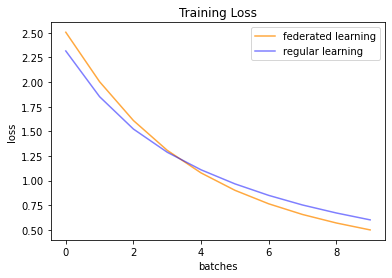

In [ ]:
plt.plot(loss_fed, color='darkorange', label='federated learning', alpha=0.75)
plt.plot(loss_regular, color='blue', label='regular learning', alpha=0.5)
plt.title('Training Loss')
plt.xlabel('batches')
plt.ylabel('loss')
plt.legend()

As mentioned earlier, PySyft and federated learning in general can have a few efficiency problems. Here, we see that the federated learning model took nearly 47 times as long to train per epoch on average than the regular model.

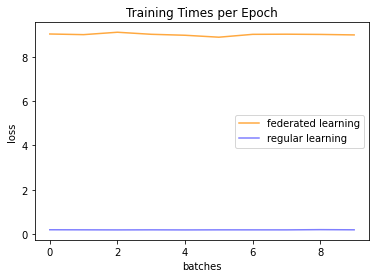

In [ ]:
plt.plot(time_fed['epoch'], color='darkorange', label='federated learning', alpha=0.75)
plt.plot(time_regular['epoch'], color='blue', label='regular learning', alpha=0.5)
plt.title('Training Times per Epoch')
plt.xlabel('batches')
plt.ylabel('loss')
plt.legend()

In order to better diagnose this issue, we also recorded the time it took to actually perform a forward and backward pass during training. This can help provide insight into the actual slow step of the learning process. Each network update for each method can be split up in two parts. The first is data preparation and the other is the actual forward and backward pass. For the regular model, data preparation involves loading the data and labels onto the GPU. For the federated model, this also involves sending the model to the virtual worker's process and after the network update, copying the new model back to the main process. 

Text(0.5, 1.0, 'Federated Learning Run Time Breakdown')

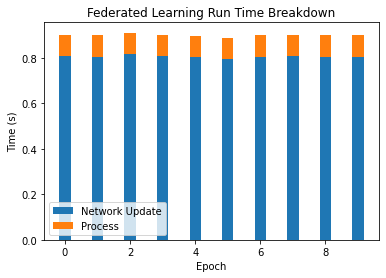

In [ ]:
labels = np.arange(10)
width = 0.35

fig, ax = plt.subplots()

ax.bar(labels, time_fed['process'], width, label='Network Update')
ax.bar(labels, time_fed['update'], width, bottom=time_fed['process'], label='Process')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Time (s)')
ax.set_title('Federated Learning Run Time Breakdown')

Text(0.5, 1.0, 'Regular Learning Run Time Breakdown')

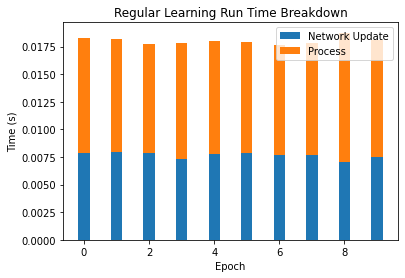

In [ ]:
labels = np.arange(10)
width = 0.35

fig, ax = plt.subplots()

ax.bar(labels, time_regular['process'], width, label='Network Update')
ax.bar(labels, time_regular['update'], width, bottom=time_regular['process'], label='Process')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Time (s)')
ax.set_title('Regular Learning Run Time Breakdown')

Above, we chart the process and network update times for each batch for both the regular and federated learning results. Here, we see that PySyft spends a majority of time in the process steps, which mainly involves sending the model to and from the main process and virtual remote nodes. This seems to be the major contributor to the slow training times when using PySyft. The actual network updates also take a bit longer in the federated learning environment than in the regular learning times. This is likely due to the additional Multi-Party Computation (MPC) protocols that PySyft uses to ensure safe communication between remote nodes.

## The Cost of Privacy

Here, we learned that federated learning offers similar performance to regular learning in terms of training loss, however, we also see that PySyft can lead to almost a 47x increase in training times. This shows us that privacy can come at a cost. In this case, the price we pay is computational efficiency. Despite this, federated learning still solves many problems that a centralized data storage strategy just cannot solve. For example, when there is a high volume of data distributed across many nodes, aggregating and storing all this data in a central database can be very expensive.

## Comparison to Differential Privacy.

We follow this analysis in a separate analysis and extend upon the original [PySyft federated learning notebook](https://github.com/OpenMined/PySyft/blob/PySyft/syft_0.2.x/examples/tutorials/Part%2007%20-%20Federated%20Learning%20with%20Federated%20Dataset.ipynb) by comparing the performance of this model to another privacy preserving technique, Differential Privacy.